# Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) seeks to group data into clusters based on their properties and then allow us to predict which cluster a new member belongs.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn import datasets

We'll use a dataset generator that is part of [scikit-learn](https://scikit-learn.org/stable/index.html) called [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).  This generates data that falls into 2 different sets with a shape that looks like half-moons.

In [5]:
def generate_data():
    xvec, val = datasets.make_moons(200, noise=0.2)

    # encode the output to be 2 elements
    x = []
    v = []
    for xv, vv in zip(xvec, val):
        x.append(np.array(xv))
        v.append(vv)

    return np.array(x), np.array(v)

```{tip}
By adjusting the `noise` parameter, we can blur the boundary between the two datasets, making the classification harder.
```

In [11]:
x, v = generate_data()

Let's look at a point and it's value

In [12]:
print(f"x = {x[0]}, value = {v[0]}")

x = [0.40111178 0.66685986], value = 0


Now let's plot the data

In [13]:
def plot_data(x, v):
    xpt = [q[0] for q in x]
    ypt = [q[1] for q in x]

    fig, ax = plt.subplots()
    ax.scatter(xpt, ypt, s=40, c=v, cmap="viridis")
    ax.set_aspect("equal")
    return fig

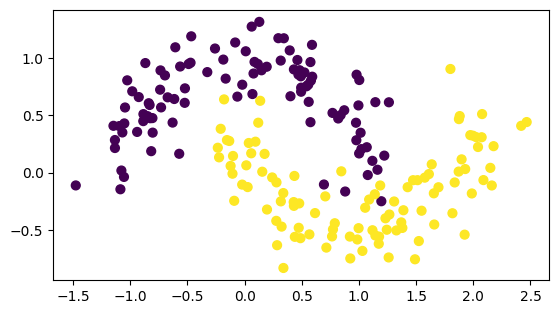

In [14]:
fig = plot_data(x, v)

We want to partition this domain into 2 regions, such that when we come in with a new point, we know which group it belongs to.

First we setup and train our network

In [16]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.optimizers import RMSprop

In [18]:
model = Sequential()
model.add(Input((2,)))
model.add(Dense(50, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [19]:
rms = RMSprop()
model.compile(loss='binary_crossentropy',
              optimizer=rms, metrics=['accuracy'])

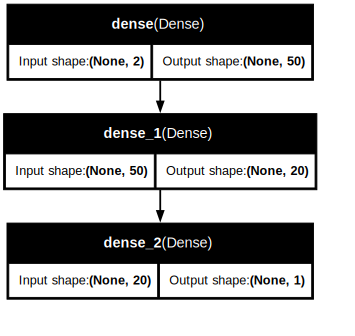

In [21]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

```{important}
We seem to need a lot of epochs here to get a good result
```

In [22]:
epochs = 100
results = model.fit(x, v, batch_size=50, epochs=epochs)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5653 - loss: 0.6825
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8527 - loss: 0.6181
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8447 - loss: 0.5879
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8640 - loss: 0.5551
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8400 - loss: 0.5365
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8833 - loss: 0.4867
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8467 - loss: 0.4856
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8660 - loss: 0.4639
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8507 - loss: 0.4425
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8273 - loss: 0.4418
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8587 - loss: 0.4055
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8313 - loss: 0.4085
E

In [23]:
score = model.evaluate(x, v, verbose=0)
print(f"score = {score[0]}")
print(f"accuracy = {score[1]}")

score = 0.1734350323677063
accuracy = 0.9300000071525574


Let's look at a prediction.  We need to feed in a single point as an array of shape `(N, 2)`, where `N` is the number of points

In [24]:
res = model.predict(np.array([[-2, 2]]))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[4.9620135e-09]], dtype=float32)

We see that we get a floating point number.  We will need to convert this to 0 or 1 by rounding.

Let's plot the partitioning

In [25]:
M = 128
N = 128

xmin = -1.75
xmax = 2.5
ymin = -1.25
ymax = 1.75

xpt = np.linspace(xmin, xmax, M)
ypt = np.linspace(ymin, ymax, N)

To make the prediction go faster, we want to feed in a vector of these points, of the form:
```
[[xpt[0], ypt[0]],
 [xpt[1], ypt[1]],
 ...
]
```

We can see that this packs them into the vector

In [26]:
pairs = np.array(np.meshgrid(xpt, ypt)).T.reshape(-1, 2)
pairs[0]

array([-1.75, -1.25])

Now we do the prediction.  We will get a vector out, which we reshape to match the original domain.

In [27]:
res = model.predict(pairs, verbose=0)
res.shape = (M, N)

Finally, round to 0 or 1

In [28]:
domain = np.where(res > 0.5, 1, 0)

and we can plot the data

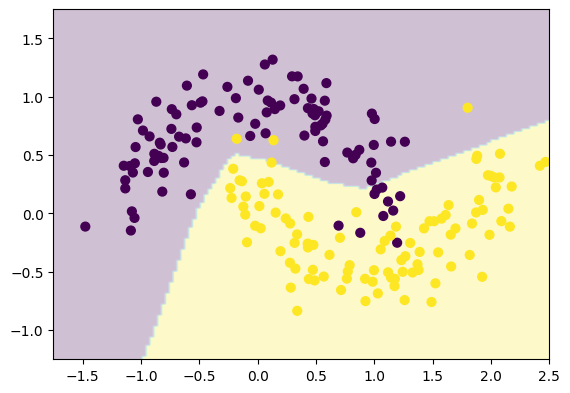

In [29]:
fig, ax = plt.subplots()
ax.imshow(domain.T, origin="lower",
          extent=[xmin, xmax, ymin, ymax], alpha=0.25)
xpt = [q[0] for q in x]
ypt = [q[1] for q in x]

ax.scatter(xpt, ypt, s=40, c=v, cmap="viridis")